In [3]:
#Tu si importujeme potrebn0 kniznice
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2


In [4]:
#Nacitame si dataset a nasledne zistime zakladne informacie o datasete, 
#ake atributy a typy sa tu nachadzaju a tiez aj zistenie chybajucich hodnot, nastavili sme si aj styl grafov
data = pd.read_csv('data.csv')

print(data.info())

sns.set(style="whitegrid")

print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

In [5]:
#Rozdelili sme si vsetky atrivuty podla numerickych a kategorickych premennych
num=['months_as_customer','age','policy_deductable','policy_annual_premium',
    'umbrella_limit','capital-gains','capital-loss','incident_hour_of_the_day',
    'number_of_vehicles_involved','bodily_injuries','witnesses','total_claim_amount',
    'injury_claim','property_claim','vehicle_claim','auto_year']

cat= ['policy_bind_date','policy_state','policy_csl','insured_sex','insured_education_level',
    'insured_occupation','insured_hobbies','insured_relationship','incident_date',
    'incident_type','collision_type','incident_severity','authorities_contacted','incident_state',
    'incident_city','incident_location','property_damage','police_report_available',
    'auto_make','auto_model']

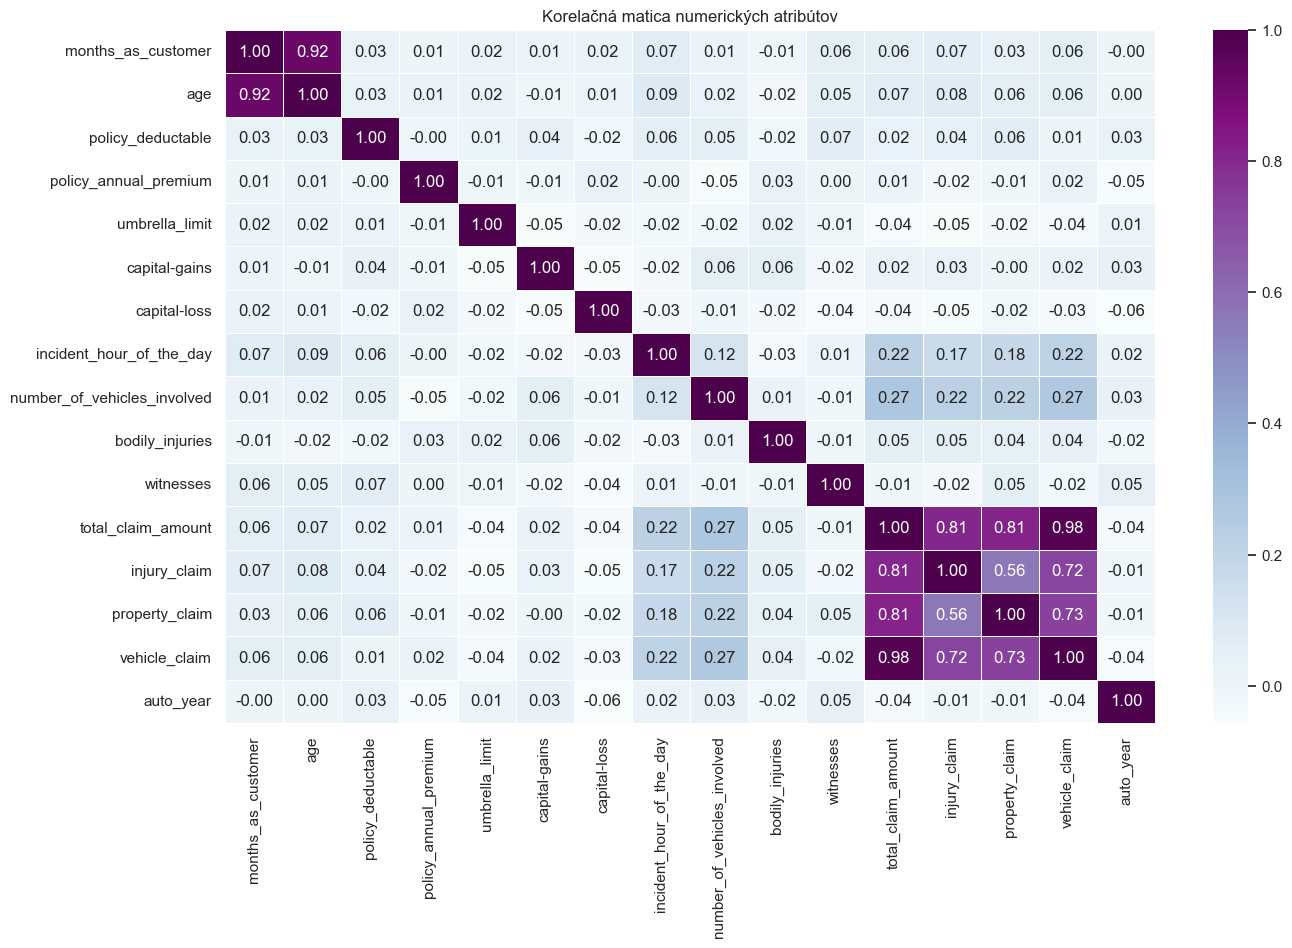

In [6]:
#Nasledne sme si vztvorili korelačnu matica numerických atribútov, nastavili sme aj farbu
#zistili sme ktore atributy su medzi sebpu najviac korelovane
plt.figure(figsize=(15, 9))
correlation = data[num].corr() 
sns.heatmap(correlation, annot=True, cmap="BuPu", fmt=".2f", linewidths=0.5)
plt.title("Korelačná matica numerických atribútov")
plt.show()


In [35]:
# Vytvorili sme skript, ktory nam pomaha identifikovať najvyznamnejšie kategoricke atributy suvisiace s cielovou premennou 'fraud_reported'
# Najprv sme zakódovali všetky kategórie do číselnej podoby pomocou LabelEncoder, potom sme pomocou chi-kvadrát testu (SelectKBest s metrikou chi2) vyhodnotili,
# ktore atributy maju najsilnejsiu statisticku závislosť s cielovym atributom. 
# Na záver sme výsledky (chí-kvadrát skóre a p-hodnoty) zoradili a zobrazili pre lepsi prehlad o dolezitosti jednotlivých atributov.

target = 'fraud_reported'
label_encoders = {}

#zakodujeme hodnoty v danom stlpci do ciselnej formy
for column in cat:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column].astype(str))

label_encoders[target] = LabelEncoder()
data[target] = label_encoders[target].fit_transform(data[target].astype(str))

# rozdelili sme data na vstupné atributy (X) a cielovu premennu (y)
X = data[cat]
y = data[target]


# k = počet najlepsích atribútov, ktoré chceme vybrať; tu berieme všetky
k = len(cat) 

#Inicializacia SelectKBest s chí-kvadrát testom
chi2_selector = SelectKBest(chi2, k=k)

#Vytrenovali sme selektor na datach X a cielovej premennej y
chi2_selector.fit(X, y)

#ziskame binárne pole (True/False), ktoré oznacuje vybrané atributy
selected_indices = chi2_selector.get_support()

#na základe indexov vyberieme nazvy atributov, ktore boli vyhodnotené ako najlepsie
selected_features = [cat[i] for i, value in enumerate(selected_indices) if value]

# teraz sme dostali chí-kvadrát skore a p-hodnoty pre vsetky testované atributy
chi2_scores = chi2_selector.scores_
p_values = chi2_selector.pvalues_

#"Tabulka" lepsej prehladnosti atributov
feature_scores = pd.DataFrame({
    'Atribút': cat,
    'Chí-kvadrát skóre': chi2_scores,
    'p-hodnota': p_values
})

#Zoradili sme výsledky zostupne - to znamena cim vvyssie skore to znamena silnejsi vztah s cielovou premennou)
feature_scores_sorted = feature_scores.sort_values(by='Chí-kvadrát skóre', ascending=False)
print("Chí-kvadrát test pre výber najlepších kategorických atribútov:")
print(feature_scores_sorted)

Chí-kvadrát test pre výber najlepších kategorických atribútov:
                    Atribút  Chí-kvadrát skóre     p-hodnota
11        incident_severity         122.804296  1.539047e-28
15        incident_location         105.554660  9.231600e-25
8             incident_date          18.656051  1.565496e-05
6           insured_hobbies          16.206539  5.679772e-05
12    authorities_contacted          12.664567  3.726509e-04
10           collision_type           8.229651  4.121145e-03
0          policy_bind_date           7.398634  6.527344e-03
13           incident_state           3.785108  5.171057e-02
5        insured_occupation           2.563391  1.093638e-01
9             incident_type           2.530024  1.116985e-01
14            incident_city           2.297660  1.295691e-01
2                policy_csl           0.940383  3.321793e-01
16          property_damage           0.650297  4.200066e-01
1              policy_state           0.589272  4.427006e-01
17  police_report_avai

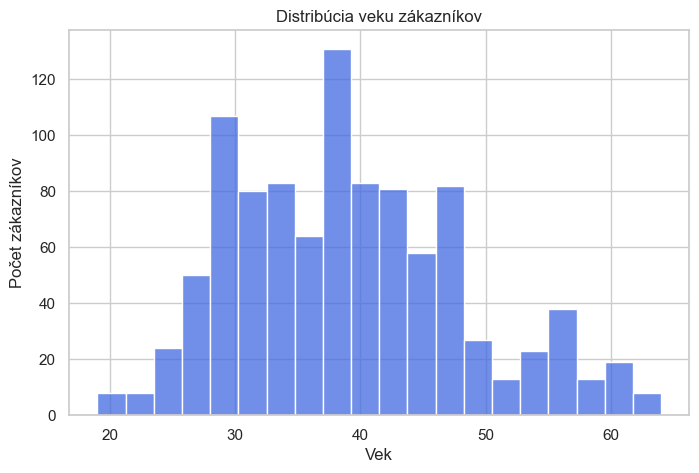

In [8]:
# vytvorili sme graf rozloženia atributu 'age' 
plt.figure(figsize=(8, 5))
sns.histplot(data['age'], bins=20, color="royalblue")
plt.title("Distribúcia veku zákazníkov")
plt.xlabel("Vek")
plt.ylabel("Počet zákazníkov")
plt.show()

# Vek je rovnomerne rozložený s miernym narastom v strednej casti
# vidime ze najviac zákaznikov je vo veku okolo 35-50 rokov.

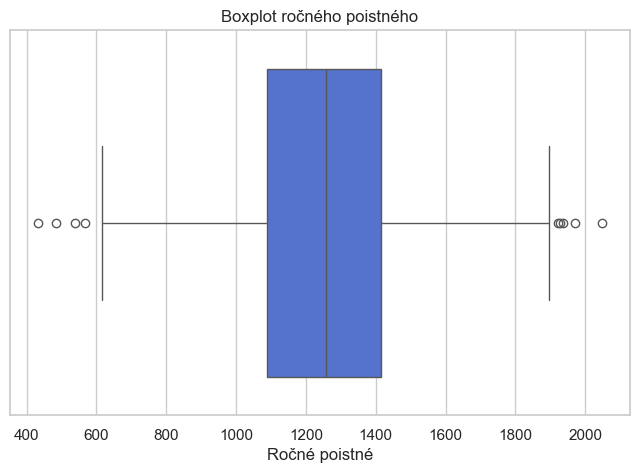

In [9]:
#Vytvorili sme boxplot pre atribut 'policy_annual_premium'
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['policy_annual_premium'], color="royalblue")
plt.title("Boxplot ročného poistného")
plt.xlabel("Ročné poistné")
plt.show()


C:\Users\Miriam\AppData\Local\Temp\ipykernel_4524\4073092248.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data['incident_type'], palette="coolwarm", order=data['incident_type'].value_counts().index)


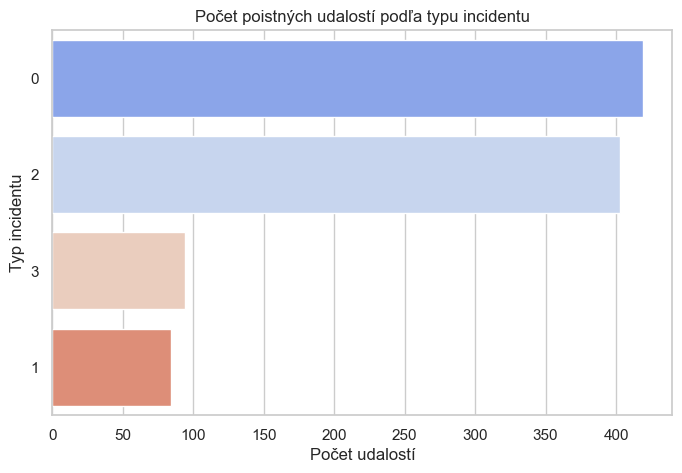

In [10]:
# Vykreslili sme si aj pocet poistných udalostí podla atributu 'incident_type'
plt.figure(figsize=(8, 5))
sns.countplot(y=data['incident_type'], palette="coolwarm", order=data['incident_type'].value_counts().index)
plt.title("Počet poistných udalostí podľa typu incidentu")
plt.xlabel("Počet udalostí")
plt.ylabel("Typ incidentu")
plt.show()

# zistili sme ze vacsina poistných udalosti su kolizie vozidiel a ukradnute vozidla


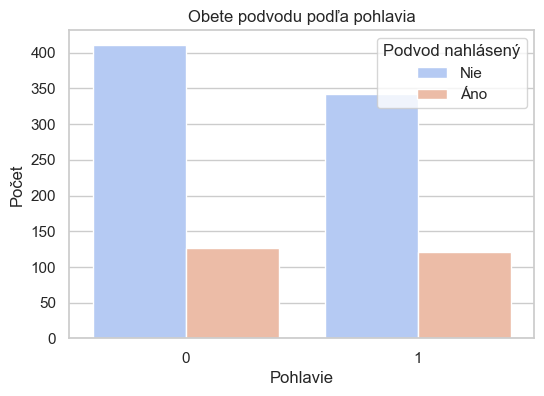

In [11]:
# vykreslenie hlavneho cieloveho atributu - podvody podľa pohlavia
plt.figure(figsize=(6, 4))
sns.countplot(x=data['insured_sex'], hue=data['fraud_reported'], palette="coolwarm")
plt.title("Obete podvodu podľa pohlavia")
plt.xlabel("Pohlavie")
plt.ylabel("Počet")
plt.legend(title="Podvod nahlásený", labels=["Nie", "Áno"])
plt.show()

# zistili sme ze o trochu viac su obete podvodov zeny, ale inak je to priblizne rozdelenie pohlavia podla nahlasenia podvodu

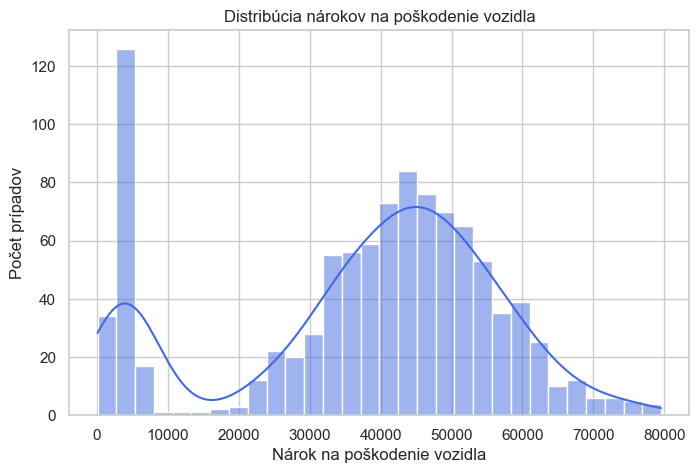

In [12]:
#Vytvorili sme graf zobrazenia narokov na poskodenie podla poctu ptipadov
plt.figure(figsize=(8, 5))
sns.histplot(data['vehicle_claim'], bins=30, kde=True, color="royalblue")
plt.title("Distribúcia nárokov na poškodenie vozidla")
plt.xlabel("Nárok na poškodenie vozidla")
plt.ylabel("Počet prípadov")
plt.show()